# Chapter 62: Bagging and Boosting

### This code generates figures 3, 4, and 5 in Chapter 62: Bagging and Boosting (vol. III)


#### Runs simulations for Example 1 in the chapter


TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.


<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs.  The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Saba Nasiri. 

required libraries:
    
1. numpy
2. matplotlib.pyplot

In [17]:
import numpy as np
import matplotlib.pyplot as plt


## Example 62.1 (Boosting a collection of threshold-based classifiers)

In [18]:
thres_x = np.array([-0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375]) # threshold values for x-direction
thres_y = np.array([-0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375]) # threshold values for y-direction
L = np.max(thres_x.shape) + np.max(thres_y.shape) #  number of classifiers we are using
reverse = np.ones((L, 1)) # will change value to -1 if the classifier is not weak and we need to reverse it
reverse_opt = np.ones((L, 1)) # will change value to -1 if the classifier is not weak and we need to reverse it
idx = np.zeros((L, 1))
error = np.zeros((L, 1))

# GENERATION OF DATA
N = 100

Ax = np.zeros((N, 3))
kn1 = 1
kn2 = 1

xtg = np.array([0])
ytg = np.array([0])
xtr = np.array([0])
ytr = np.array([0])

for n in range(N):
    h1 = np.random.rand() -0.5
    h2 = np.random.rand() -0.5
    
    if 0.25 <= h1 and h1 <= 0.5:
        Ax[n, :] = np.array([h1, h2, 1]) # gamma(n)=+1
        xtg = np.concatenate([xtg, Ax[n, :][0].reshape(-1,)]) # green training points
        ytg = np.concatenate([ytg, Ax[n, :][1].reshape(-1,)])
        kn1 = kn1 + 1
        
    elif -0.25 <= h1 and h1 < 0.25 and -0.5 <= h2 and h2 <= -0.25:
        Ax[n, :] = np.array([h1, h2, 1]) # gamma(n)=+1
        xtg = np.concatenate([xtg, Ax[n, :][0].reshape(-1,)]) # green training points
        ytg = np.concatenate([ytg, Ax[n, :][1].reshape(-1,)])
        kn1 = kn1 + 1
        
    elif -0.5 <= h1 and h1 <= -0.25:
        Ax[n, :] = np.array([h1, h2, -1]) # gamma(n)=-1
        xtr = np.concatenate([xtr, Ax[n, :][0].reshape(-1,)]) # red training points
        ytr = np.concatenate([ytr, Ax[n, :][1].reshape(-1,)])
        kn2 = kn2 + 1
        
    else:
        Ax[n, :] = np.array([h1, h2, -1]) # gamma(n)=-1
        xtr = np.concatenate([xtr, Ax[n, :][0].reshape(-1,)]) # red training points 
        ytr = np.concatenate([ytr, Ax[n, :][1].reshape(-1,)])
        kn2 = kn2 + 1
             
xtg = xtg[1::]
ytg = ytg[1::]
xtr = xtr[1::]
ytr = ytr[1::]

N = np.max(Ax.shape)
P = np.random.permutation(N) # randomly permuting the rows of Ax
A = np.zeros((N, 3))

for n in range(N):
    A[n, :] = Ax[P[n], :]
    
C = A[:, 2] # color map

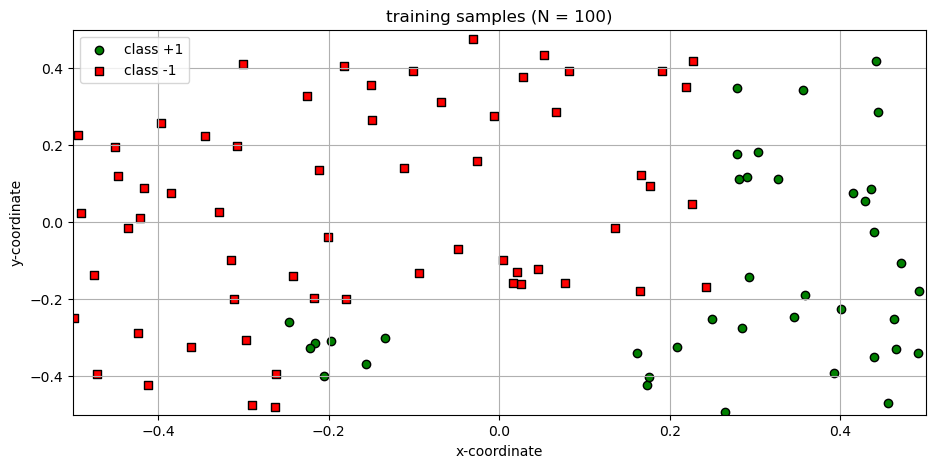

In [19]:
# figure 3 (data points)

f, axs =  plt.subplots(1, 1, figsize=(11,5))

axs.scatter(xtg, ytg, c = 'green', edgecolors='black', marker='o')
axs.scatter(xtr, ytr, c = 'red', edgecolors='black', marker='s')
axs.set_ylabel('y-coordinate')
axs.set_xlabel('x-coordinate')
axs.grid()
axs.set_title('training samples (N = 100)')
axs.legend(['class +1', 'class -1']);
axs.set_xlim([-0.5, 0.5])
axs.set_ylim([-0.5, 0.5])

#plt.savefig('fig 62.3.pdf')

(Figure 62.3)

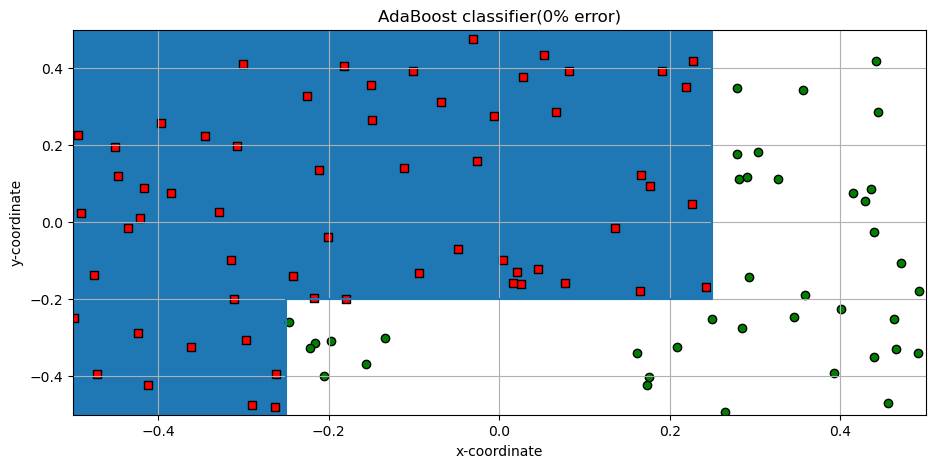

In [20]:
# figure 4

f, axs =  plt.subplots(1, 1, figsize=(11,5))

x = [-0.5, -0.25, -0.25, 0.25, 0.25]
y = [-0.6, -0.6, -0.2, -0.2, 0.5]
axs.plot(x, y)
yy = [0.5, 0.5, 0.5, 0.5, 0.5]
axs.fill_between(x, y, yy)
axs.scatter(xtg, ytg, c = 'green', edgecolors='black', marker='o')
axs.scatter(xtr, ytr, c = 'red', edgecolors='black', marker='s')
axs.set_ylabel('y-coordinate')
axs.set_xlabel('x-coordinate')
axs.grid()
axs.set_xlim([-0.5, 0.5])
axs.set_ylim([-0.5, 0.5])
axs.set_title('AdaBoost classifier(0% error)');

# plt.savefig('fig 62.4.pdf')

(Figure 62.4)

In [21]:
# CHECKING WHETHER THE CLASSIFIERS ARE WEAK; IF ANY IS NOT WEAK
# WE REVERSE ITS CLASS DECISION

N_train = N
num = np.zeros((L,)) # saves number of errors for each classifier
num_percent = np.zeros((L,))
gamma_hat = np.zeros((N, L)) # each column contains the gamma estimates for each classifier
error = np.zeros((L,)) # counting weighted errors for each classifier
 
for n in range(N_train):
    for ell in np.arange(0, int(L/2), 1): # x-axis first
        if A[n, 0] >= thres_x[ell]:
            gamma_hat[n, ell] = 1
        else:
            gamma_hat[n, ell] = -1
            
        if A[n, 2]*gamma_hat[n, ell] <= 0: # errorneous decision
            num[ell] = num[ell] + 1 # number of errors
            
    for ell in np.arange(0, int(L/2), 1): #  y-axis first
        if A[n, 1] >= thres_y[ell]:
            gamma_hat[n, ell+int(L/2)] = 1
        else:
            gamma_hat[n, ell+int(L/2)] = -1
            
        if A[n, 2]*gamma_hat[n, ell+int(L/2)] <= 0: # errorneous decision
            num[ell+int(L/2)] = num[ell+int(L/2)] + 1 # number of errors
            

for ell in range(L):
    num_percent[ell] = (num[ell]/N_train) * 100
    if num_percent[ell] >= 50:
        reverse[ell] = -1 # we need to reverse the decision of the classifier to make it weak
    
    
print('Which classifiers need to be reversed to become weak')
print(np.concatenate([np.arange(1, L+1).reshape(-1, 1),reverse], axis = 1))


Which classifiers need to be reversed to become weak
[[ 1.  1.]
 [ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8. -1.]
 [ 9. -1.]
 [10. -1.]
 [11. -1.]
 [12. -1.]
 [13. -1.]
 [14.  1.]]


In [22]:
# WE NOW INITIATE THE BOOSTING OPERATION

d = (1/N_train)*np.ones((N_train,)) # equal weights initially
gamma_opt = np.zeros((N, L)) # each column contains the gamma estimates for each optimal classifier
num_percent_opt = np.zeros((L,)) # error of optimal classifier
threshold = np.zeros((L,))
direction = []
alpha = np.zeros((L,))


for t in range(L):
# repeat L times
# we run each classifier on the data and find its error and pick
# the best and repeat    

    num = np.zeros((L,)) # saves number of errors for each classifier
    num_percent = np.zeros((L,))
    gamma_hat = np.zeros((N, L)) # each column contains the gamma estimates for each classifier
    error = np.zeros((L,)) # counting weighted errors for each classifier
    for n in range(N_train):
        for ell in range(int(L/2)): # x-axis first
            if A[n, 0] >= thres_x[ell]:
                gamma_hat[n, ell] = +1*reverse[ell]
            else:
                gamma_hat[n, ell] = -1*reverse[ell]
                
            if A[n, 2]*gamma_hat[n, ell] <= 0: # errorneous decision
                num[ell] = num[ell] + 1 # number of errors
                error[ell] = error[ell] + d[n] # weighted error
        
        for ell in range(int(L/2)): #  y-axis first
            if A[n, 1] >= thres_y[ell]:
                gamma_hat[n, ell+int(L/2)] = +1*reverse[ell+int(L/2)]
            else:
                gamma_hat[n, ell+int(L/2)] = -1*reverse[ell+int(L/2)]
            
            if A[n, 2]*gamma_hat[n, ell+int(L/2)] <= 0: # errorneous decision
                num[ell+int(L/2)] = num[ell+int(L/2)] + 1 # number of errors
                error[ell+int(L/2)] = error[ell+int(L/2)] + d[n] # weighted error
    
    for ell in range(L):
        num_percent[ell] = (num[ell]/N_train)*100 # percentage of errors on training data
        
    er = np.min(error) # find the classifier with smallest weighted error and collect its statistics
    ind = np.argmin(error)
    
    if (0.5-10**(-6)) <= er and er <= (0.5+10**(-6)): # if error is essentially 0.5, we ignore this case since the algorithm stops learning
        if ind == 0:
            error2 = error[1:L]
            er = np.min(error2)
            ind = np.argmin(error2)
            ind = ind + 1
        
        if ind == L-1:
            error2 = error[0:L-1]
            er = np.min(error2)
            ind = np.argmin(error2)
            
        if ind>0 and ind < L-1:
            error2 = np.concatenate([error[0:ind], error[ind+1:L]]) ###
            er = np.min(error2)
            ind2 = np.argmin(error2)
            if ind2 >= ind:
                ind = ind+1
            else:
                ind = ind2
    idx[t] = ind
    alpha[t] = 0.5*np.log((1-er)/er)
    gamma_opt[:, t] = gamma_hat[:, ind]
    num_percent_opt[t] = num_percent[ind]
    reverse_opt[t] = reverse[ind]
    
    for n in range(N_train):
        d[n] = d[n] * np.exp(-alpha[t]*A[n,2]*gamma_opt[n,t])
        
    d = d/np.sum(d)
    
    print(f'Results after iteration t={t}')
    print('Percentage (1st col) and weighted (2nd col) errors by all individual classifiers on training data'); 
    print(np.concatenate([np.arange(1, L+1).reshape(-1, 1), num_percent.reshape(-1, 1), error.reshape(-1, 1)], axis = 1)) #
 
    ss = idx[t]
    aa = alpha[t]
    bb = num_percent_opt[t]
    xx = reverse_opt[t]
    
    print(f'Index of best classifier for this iteration is t={ss[0]}');
    print(f'Its alpha value is t={aa}');
    print(f'Its error rate (%) on training data is bb={bb}');
    print(f'Its DECISION needs to be reversed{xx}');
    
    if ss > int(L/2)-1:
        cc = thres_y[int(ss[0])-(int(L/2)-1)]
        threshold[t] = cc
        direction.append('x')
        print(f'optimal classifier is along y-direction with threshold ={cc}');
    else:
        cc = thres_x[int(ss[0])]
        threshold[t] = cc
        direction.append('y')
        print(f'optimal classifier is along x-direction with threshold ={cc}');
    

Results after iteration t=0
Percentage (1st col) and weighted (2nd col) errors by all individual classifiers on training data
[[ 1.   47.    0.47]
 [ 2.   36.    0.36]
 [ 3.   34.    0.34]
 [ 4.   26.    0.26]
 [ 5.   16.    0.16]
 [ 6.   12.    0.12]
 [ 7.   24.    0.24]
 [ 8.   38.    0.38]
 [ 9.   27.    0.27]
 [10.   35.    0.35]
 [11.   40.    0.4 ]
 [12.   43.    0.43]
 [13.   48.    0.48]
 [14.   47.    0.47]]
Index of best classifier for this iteration is t=5.0
Its alpha value is t=0.9962150823451031
Its error rate (%) on training data is bb=12.0
Its DECISION needs to be reversed[1.]
optimal classifier is along x-direction with threshold =0.25
Results after iteration t=1
Percentage (1st col) and weighted (2nd col) errors by all individual classifiers on training data
[[ 1.         47.          0.26704545]
 [ 2.         36.          0.20454545]
 [ 3.         34.          0.44507576]
 [ 4.         26.          0.39962121]
 [ 5.         16.          0.34280303]
 [ 6.         12.  

In [23]:
# DETERMINING PERFORMANCE OF AGGREGATE CLASSIFIER

g_class = np.zeros((N,))
num_overall = 0
g_class = np.zeros((N_train,))

for n in range(N_train):
    g_hat = 0
    for t in range(L):
        g_hat = g_hat + alpha[t] * gamma_opt[n, t]
        
    if g_hat >= 0:
        g_class[n] = 1
    else:
        g_class[n] = -1
       
    if A[n, 2]*g_class[n] <= 0:
        num_overall = num_overall + 1


num_percent_overall = (num_overall/N_train)*100;
print(f'Empirical error rate for the AdaBoost classifier on training data={num_percent_overall}');
print('Index of classifiers selected by AdaBoost:')
print(idx)

print('Weighting coefficients for the optimal classifiers selected by  AdaBoost, along with whether they are reversed or not and their thresholds:')
print(np.concatenate([alpha.reshape(-1, 1), reverse_opt, threshold.reshape(-1, 1)], axis = 1))
print('direction')
print(direction)
   

Empirical error rate for the AdaBoost classifier on training data=0.0
Index of classifiers selected by AdaBoost:
[[5.]
 [8.]
 [1.]
 [5.]
 [8.]
 [1.]
 [5.]
 [8.]
 [1.]
 [5.]
 [8.]
 [1.]
 [5.]
 [8.]]
Weighting coefficients for the optimal classifiers selected by  AdaBoost, along with whether they are reversed or not and their thresholds:
[[ 0.99621508  1.          0.25      ]
 [ 0.85405472 -1.         -0.125     ]
 [ 0.99241278  1.         -0.25      ]
 [ 0.80015271  1.          0.25      ]
 [ 0.78973146 -1.         -0.125     ]
 [ 0.75415466  1.         -0.25      ]
 [ 0.74433439  1.          0.25      ]
 [ 0.73444364 -1.         -0.125     ]
 [ 0.72997488  1.         -0.25      ]
 [ 0.7266765   1.          0.25      ]
 [ 0.72487143 -1.         -0.125     ]
 [ 0.72367868  1.         -0.25      ]
 [ 0.72297523  1.          0.25      ]
 [ 0.72252928 -1.         -0.125     ]]
direction
['y', 'x', 'y', 'y', 'x', 'y', 'y', 'x', 'y', 'y', 'x', 'y', 'y', 'x']


In [24]:
n = -1
k1 = 0
k2 = 0
xg = np.array([0])
yg = np.array([0])
xr = np.array([0])
yr = np.array([0])
gamma_hat = np.zeros((np.arange(-0.5, 0.505, 0.005).shape[0]**2, L))
g_class_h = np.zeros((np.arange(-0.5, 0.505, 0.005).shape[0]**2, ))

for z1 in np.arange(-0.5, 0.505, 0.005):
    for z2 in np.arange(-0.5, 0.505, 0.005):
        n = n+1
        hn1 = z1
        hn2 = z2
        
        for ell in range(int(L/2)): # x-axis first
            if hn1 >= thres_x[ell]:
                gamma_hat[n, ell] = +1*reverse[ell]
            else:
                gamma_hat[n, ell] = -1*reverse[ell]
        
        for ell in range(int(L/2)): # y-axis first
            if hn2 >= thres_y[ell]:
                gamma_hat[n, ell+int(L/2)] = +1*reverse[ell+int(L/2)]
            else:
                gamma_hat[n, ell+int(L/2)] = -1*reverse[ell+int(L/2)]
        
        g_hat = 0
        for t in range(L):
            g_hat = g_hat + alpha[t]*gamma_hat[n,int(idx[t])]
            
        if g_hat >= 0:
            g_class_h[n] = 1
            xg = np.concatenate([xg.reshape(-1, 1), z1.reshape(-1, 1)])
            yg = np.concatenate([yg.reshape(-1, 1), z2.reshape(-1, 1)])
            k1 = k1 + 1
        else:
            g_class_h[n] = -1
            xr = np.concatenate([xr.reshape(-1, 1), z1.reshape(-1, 1)])
            yr = np.concatenate([yr.reshape(-1, 1), z2.reshape(-1, 1)])
            k2 = k2 + 1
        
        

xg = xg[1::].reshape(1,-1)[0]
yg = yg[1::].reshape(1,-1)[0]
xr = xr[1::].reshape(1,-1)[0]
yr = yr[1::].reshape(1,-1)[0]

C = A[:, 2] # color map

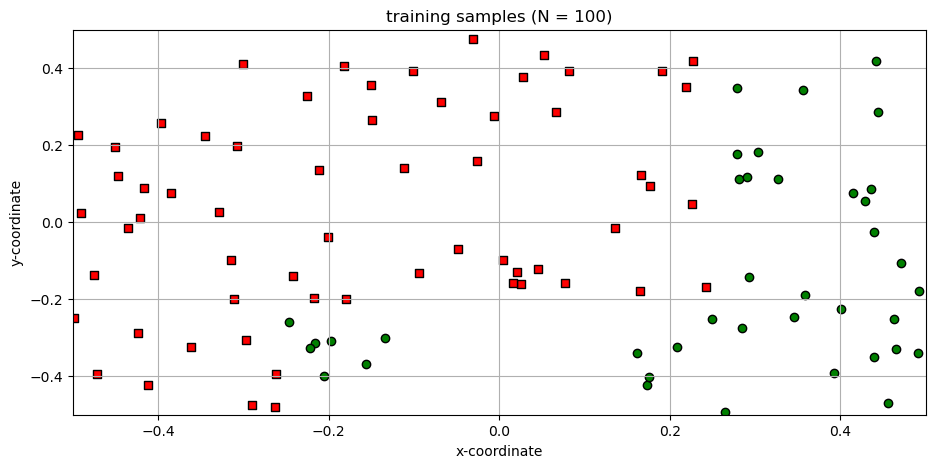

In [26]:
# figure 4 (AdaBoost classifier)

f, axs =  plt.subplots(1, 1, figsize=(11,5))

axs.scatter(xtg, ytg, c = 'green', edgecolors='black', marker='o')
axs.scatter(xtr, ytr, c = 'red', edgecolors='black', marker='s')
axs.set_ylabel('y-coordinate')
axs.set_xlabel('x-coordinate')
axs.grid()
axs.set_xlim([-0.5, 0.5])
axs.set_ylim([-0.5, 0.5])
axs.set_title('training samples (N = 100)');

# plt.savefig('fig 62.5.pdf')

(Figure 62.5)